In [2]:
# Basic libraries that we will need, you can copy - paste it:)
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from google.cloud import bigquery

## Call Query and data fetch example 
- check some of the dataset (e.g., first 10 rows)

In [4]:
# In a Kaggle environment, it is common to set project=None or omit it entirely.
# Kaggle automatically uses the authenticated project.
try:
    client = bigquery.Client()
    print("BigQuery client initialized successfully. Reconfirming permissions...")
except Exception as e:
    print(f"Client initialization error: {e}")

Using Kaggle's public dataset BigQuery integration.
BigQuery client initialized successfully. Reconfirming permissions...


In [ ]:

# Exploring the data
query_= """
SELECT
-- Selecting all columns
  * FROM
-- You can select any day or month you want, the data will be the same because Google analytics collects data based on the same features
  `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
LIMIT
  10
  """

# -----------------------------------------------------------------------------------------
# Use the BigQuery client object to 'send' the SQL query to the BigQuery server and 'request' execution.
# This function starts the query execution itself but does not fetch the results immediately;
# it returns a 'Job Object', which manages the state of the query operation.
query_result = client.query(query_)

# -----------------------------------------------------------------------------------------
# Use the 'Job Object' (query_result) obtained in the previous step to wait for and retrieve 
# the results of the query execution.
# The to_dataframe() method converts the BigQuery result table into a Pandas 'DataFrame' format,
# which is the most common format used for data analysis.
# Note: Data is actually downloaded over the network during this process.
summary_ = query_result.to_dataframe()

# -----------------------------------------------------------------------------------------
# Output the created DataFrame variable (summary).
# This will display the 10 rows from the preceding query (LIMIT 10) and all columns (SELECT *).
summary_

## Sequential Querying and Data Flattening by Structure Type
- STRUCT (RECORD): use dot (.)
- ARRAY (REPEATED): use UNNEST

In [ ]:
# -----------------------------------------------------------------------------------------
# Google Analytics data consists of basic information and detailed information with a nested structure.
# This query retrieves the non-nested, basic session identifier information as a first step.
# -----------------------------------------------------------------------------------------

# Links provided to documentation for UNNEST, ARRAY, and STRUCT for deeper learning.
# UNNEST, ARRAY, STRUCT documenation - https://cloud.google.com/bigquery/docs/reference/standard-sql/arrays

# # select first couple of columns that are not nested(basically which are not a mess)
# query_part1 = """
# SELECT
# 	visitorId, visitNumber, visitId, visitStartTime, date
# FROM 
# 	# Selecting data from a single table for August 1, 2017.
# 	`bigquery-public-data.google_analytics_sample.ga_sessions_20170701`
# """

query_part1 = """
SELECT
  visitorId, visitNumber, visitId, visitStartTime, date
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE _TABLE_SUFFIX BETWEEN '20170701' and '20170702'
"""

# Creates a 'Job Object' to execute the query using the BigQuery client.
safe_query_job = client.query(query_part1)

# Waits for the job to complete, then converts the result to a Pandas DataFrame and stores it.
query_part1_df = safe_query_job.to_dataframe()


# -----------------------------------------------------------------------------------------
# The 'totals' column is a nested column containing session summary information (e.g., page views, transactions)
# in a STRUCT format. The UNNEST operation flattens this nested structure into individual columns.
# Note: This query targets the entire month of July 2017 (Wildcard table).
# -----------------------------------------------------------------------------------------

# # unnest totals column
# query_totals = """
# SELECT 
# 	# Use UNNEST to retrieve all fields (*) inside the 'totals' STRUCT as individual columns.
# 	* FROM 
# 	# The ARRAY(SELECT totals FROM ...) pattern is an SQL technique used to extract and flatten
# 	# a specific nested STRUCT column.
# 	UNNEST(ARRAY(
# 		SELECT
# 			totals
# 		FROM 
# 			# Query all daily tables in July 2017 using the wildcard (*).
# 			`bigquery-public-data.google_analytics_sample.ga_sessions_*`
# 		# _TABLE_SUFFIX is used for filtering the date range when using wildcards.
# 		WHERE _TABLE_SUFFIX BETWEEN '20170701' AND '20170731'
# 	))
# """

# Only query
query_totals = """
SELECT
  * FROM
  UNNEST(ARRAY(
    SELECT
      totals
    FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE _TABLE_SUFFIX BETWEEN '20170701' and '20170702'
  ))
"""

# Execute the BigQuery query and store the result in a DataFrame.
safe_query_job = client.query(query_totals)
totals_df = safe_query_job.to_dataframe()


# -----------------------------------------------------------------------------------------
# The 'trafficSource' column contains information on how visitors reached the site 
# (campaign, source, medium, etc.). This query flattens the basic fields of the 
# 'trafficSource' STRUCT.
# -----------------------------------------------------------------------------------------

query_trafficSource = """
-- This is how you tell computer to put unnested data into separate columns
SELECT 
  # Select the required fields directly from inside the trafficSource STRUCT.
  referralPath, campaign, source, medium, keyword, adContent, isTrueDirect, campaignCode
FROM 
  # Use the UNNEST(ARRAY(SELECT ...)) pattern to extract and flatten the trafficSource STRUCT.
  UNNEST(ARRAY(
    SELECT
      trafficSource
    FROM 
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE _TABLE_SUFFIX BETWEEN '20170701' and '20170702'
  ))
"""

# Execute the BigQuery query and store the result in a DataFrame.
safe_query_job = client.query(query_trafficSource)
trafficSource_df = safe_query_job.to_dataframe()


# -----------------------------------------------------------------------------------------
# 'adwordsClickInfo' is another nested STRUCT inside 'trafficSource' (double nesting).
# This requires nested UNNEST operations to flatten the data.
# -----------------------------------------------------------------------------------------

query_trafficSource_2 = """
-- Unnesting data adwordClickinfo. Normally the data looks something like this : trafficSource.adwordsclickInfo.andsomething,
-- So that is why we need to unnest it in three levels.
SELECT 
  # Retrieve all fields (*) from the innermost 'adwordsClickInfo' STRUCT.
  *
FROM 
  # 3rd level: UNNEST the adwordsClickInfo STRUCT itself.
  UNNEST(ARRAY(
    SELECT 
      # 2nd level: Select the adwordsClickInfo field from within the trafficSource STRUCT.
      adwordsClickInfo
    FROM 
      # 1st level: UNNEST the trafficSource STRUCT itself.
      UNNEST(ARRAY(
        SELECT
          trafficSource
        FROM 
          `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE _TABLE_SUFFIX BETWEEN '20170701' and '20170702'
      ))
  ))
"""

# Execute the BigQuery query and store the result in a DataFrame.
safe_query_job = client.query(query_trafficSource_2)
query_trafficSource_2_df = safe_query_job.to_dataframe()


# -----------------------------------------------------------------------------------------
# #And now I'm doing copy-paste job just changing the data names (Repetitive task)
# The 'device' and 'geoNetwork' columns are also nested STRUCTs, so they are flattened
# in the same manner as the 'totals' column.
# -----------------------------------------------------------------------------------------

# UNNEST and retrieve the 'device' column (User environment info: OS, browser, etc.)
query_device = """
SELECT * FROM UNNEST(ARRAY(
  SELECT device
  FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE _TABLE_SUFFIX BETWEEN '20170701' and '20170702'
))
"""
safe_query_job = client.query(query_device)
device_df = safe_query_job.to_dataframe()


# UNNEST and retrieve the 'geoNetwork' column (User location info: Country, region, etc.)
query_geoNetwork = """
SELECT * FROM UNNEST(ARRAY(
  SELECT geoNetwork
  FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE _TABLE_SUFFIX BETWEEN '20170701' and '20170702'
))
"""
safe_query_job = client.query(query_geoNetwork)
geoNetwork_df = safe_query_job.to_dataframe()


# customDimensions column is nested and in array, so first needs to be deconstructed before individual columns can be extracted
# This block is commented out but demonstrates that 'customDimensions' is an ARRAY nested within a STRUCT, 
# requiring more complex UNNEST. (Handled differently in the custom_dimension query below)
# query_customDimensions = """
# ... (commented query content)
# ...
# """
# safe_query_job= client.query(query_customDimensions)
# customDimensions_df= safe_query_job.to_dataframe()


# -----------------------------------------------------------------------------------------
# The 'hits' column is a critical ARRAY containing individual interactions (page views, events, e-commerce, etc.)
# within the session. This query extracts the 'hits' STRUCT itself, but by UNNESTING the containing STRUCT,
# it results in one row per session containing the array of hit information in a single column.
# -----------------------------------------------------------------------------------------

query_hits = """
SELECT * FROM UNNEST(ARRAY(
  SELECT
    # Use STRUCT(hits) to wrap the hits array into a STRUCT before UNNESTING.
    # This approach flattens the STRUCT containing the array rather than flattening the array itself.
    STRUCT(hits)
  FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE _TABLE_SUFFIX BETWEEN '20170701' and '20170702'
))
"""
safe_query_job = client.query(query_hits)
hits_df = safe_query_job.to_dataframe()


# -----------------------------------------------------------------------------------------
# Retrieve the second group of non-nested columns (primarily user and channel information).
# Similar to the first query, this uses the same date range.
# -----------------------------------------------------------------------------------------

query_part2 = """
SELECT
  fullVisitorId, userId, clientId, channelGrouping, socialEngagementType
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE _TABLE_SUFFIX BETWEEN '20170701' and '20170702'
"""

safe_query_job = client.query(query_part2)
query_part2_df = safe_query_job.to_dataframe()


# -----------------------------------------------------------------------------------------
# The 'customDimensions' column is a STRUCT nested within an ARRAY.
# This query uses the comma (,) UNNEST approach to flatten the array,
# retrieving the index and value as individual columns.
# -----------------------------------------------------------------------------------------

custom_dimension = """
SELECT
  # Select the index and value fields inside the customDimensions array.
  param.index, param.value
FROM 
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
# Use the comma (,) after the FROM clause and UNNEST(customDimensions) AS alias 
# to flatten the array into rows and assign the alias 'param'.
, UNNEST(customDimensions) AS param
WHERE _TABLE_SUFFIX BETWEEN '20170701' and '20170702'
"""

safe_query_job = client.query(custom_dimension)
custom_dimension_df = safe_query_job.to_dataframe()




# -----------------------------------------------------------------------------------------
# Concatenation of DataFrames
# -----------------------------------------------------------------------------------------

# concat function helps you to select all data frames

# Use the pd.concat() function to combine all the previously created individual DataFrames into one.
# axis=1: Specifies concatenation along the columns (side-by-side merging).
# Warning: This assumes that the row order of each DataFrame is perfectly aligned.
all_columns = pd.concat([
    query_part1_df, totals_df, trafficSource_df, query_trafficSource_2_df, 
    device_df, geoNetwork_df, query_part2_df, custom_dimension_df 
], axis=1)

# -----------------------------------------------------------------------------------------
# Pandas Display Options Configuration
# -----------------------------------------------------------------------------------------

# Set the maximum number of rows to display to 500 when printing the DataFrame.
pd.set_option('display.max_rows', 500)

# Set the maximum number of columns to 100,000 to ensure all columns are displayed without truncation.
pd.set_option('display.max_columns', 100000)

# Set the output window width to 1000 for better alignment and display of columns on one line.
pd.set_option('display.width', 1000)


# -----------------------------------------------------------------------------------------
# Final Result Output
# -----------------------------------------------------------------------------------------
# print 1000 rows
all_columns.head(10)

# # Output the finally concatenated DataFrame to check the results.
# all_columns



## Function: Sequential Querying and Data Flattening by Structure Type
- Function 1 for STRUCT (RECORD): use dot (.)
- Function 2 for ARRAY (REPEATED): use UNNEST

In [5]:
#### ------------------ Query Function -------------------------


# Assumption: The client object is already instantiated.
# client = bigquery.Client() 

def unnest_column_to_df(client: bigquery.Client, 
                        column_name: str, 
                        start_date: str, 
                        end_date: Optional[str] = None,
                        print_head: bool = False) -> pd.DataFrame:
    """
    A function to UNNEST a specified nested column (column_name) from the 
    BigQuery ga_sessions table and return it as a Pandas DataFrame.

    Args:
        client: The BigQuery client object.
        column_name: The name of the nested column to UNNEST (e.g., 'device', 'geoNetwork').
        start_date: Start date for data querying (in YYYYMMDD format).
        end_date: End date for data querying (in YYYYMMDD format).

    Returns:
        A Pandas DataFrame containing the UNNESTED data.
    """
    
    # 1. Dynamic Query String Generation (Core Logic)
    # Uses Python's f-string feature to insert the value of the column_name variable into the query string.
    query = f"""
        SELECT * FROM UNNEST(ARRAY(
          SELECT {column_name}
          FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
          WHERE _TABLE_SUFFIX BETWEEN '{start_date}' AND '{end_date}'
        ))
    """
    
    print(f"--- Executing query for '{column_name}' ---")
    
    # 2. Execute Query and Convert to DataFrame
    query_job = client.query(query)
    df = query_job.to_dataframe()

    # Logic to toggle printing the first 5 rows
    if print_head:
        print(f"\n[Preview: {column_name} (First 5 rows)]")
        print(df.head(5))
        print("-" * 30)
    
    return df

# --------------------------------------------------------------------------------
# Function Usage Example
# --------------------------------------------------------------------------------

START_DATE = '20170701'
END_DATE = '20170702'

# ----------------------- Example 1 -----------------------
# 1. UNNEST 'device' column (Eliminates repetition 1)
device_df = unnest_column_to_df(
    client, 
    column_name='device', 
    start_date=START_DATE, 
    end_date=END_DATE,
    print_head=True
)
print(f"device_df row count: {len(device_df)}")
# device_df.head() # Can uncomment for verification

# ----------------------- Example 2 -----------------------
# 2. UNNEST 'geoNetwork' column (Eliminates repetition 2)
geoNetwork_df = unnest_column_to_df(
    client, 
    column_name='geoNetwork', 
    start_date=START_DATE, 
    end_date=END_DATE,
    print_head=True
)
print(f"geoNetwork_df row count: {len(geoNetwork_df)}")
# geoNetwork_df.head() # Can uncomment for verification

# ----------------------- Example 3 -----------------------
# 3. UNNEST 'totals' column (Eliminates further repetition)
totals_df = unnest_column_to_df(
    client, 
    column_name='totals', 
    start_date=START_DATE, 
    end_date=END_DATE,
    print_head=True    
)
print(f"totals_df row count: {len(totals_df)}")

#### ------------------------------------------------------

--- Executing query for 'device' ---


/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


device_df row count: 3943
--- Executing query for 'geoNetwork' ---
geoNetwork_df row count: 3943
--- Executing query for 'totals' ---
totals_df row count: 3943


## Table Schema check
- List schema information (not a structure mapping)

In [7]:
# Table reference
table_id = "bigquery-public-data.google_analytics_sample.ga_sessions_20170801"

# Fetch table information (metadata)
table = client.get_table(table_id)

print("--- Table Schema Check ---")
for field in table.schema:
    # Print field Name, Type, and Mode
    print(f"Name: {field.name}, Type: {field.field_type}, Mode: {field.mode}")

# Example of checking subfields (for RECORD type fields)
# print("\n--- Subfields of 'totals' ---")
# totals_field = next(f for f in table.schema if f.name == 'totals')
# for subfield in totals_field.fields:
#     print(f"  Subfield: {subfield.name}, Type: {subfield.field_type}")

--- 테이블 스키마 정보 ---
Name: visitorId, Type: INTEGER, Mode: NULLABLE
Name: visitNumber, Type: INTEGER, Mode: NULLABLE
Name: visitId, Type: INTEGER, Mode: NULLABLE
Name: visitStartTime, Type: INTEGER, Mode: NULLABLE
Name: date, Type: STRING, Mode: NULLABLE
Name: totals, Type: RECORD, Mode: NULLABLE
Name: trafficSource, Type: RECORD, Mode: NULLABLE
Name: device, Type: RECORD, Mode: NULLABLE
Name: geoNetwork, Type: RECORD, Mode: NULLABLE
Name: customDimensions, Type: RECORD, Mode: REPEATED
Name: hits, Type: RECORD, Mode: REPEATED
Name: fullVisitorId, Type: STRING, Mode: NULLABLE
Name: userId, Type: STRING, Mode: NULLABLE
Name: clientId, Type: STRING, Mode: NULLABLE
Name: channelGrouping, Type: STRING, Mode: NULLABLE
Name: socialEngagementType, Type: STRING, Mode: NULLABLE


## Schema Analysis: Structure Mapping (Big Query)
-  Purpose: explores the complex BigQuery table schema to map the nested data structure
-  Key function: Define STRUCT (Record ~ folder) and ARRAY (Repeated - UNNEST required)
-  Value: Identify which fields require the 'UNNEST' operation (final field) versus those that only require 'dot notation (. access: data value).

In [4]:
# Necessary module for writing csv/xlsx files
!pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 4.6 MB/s eta 0:00:00:00:01


In [7]:
def analyze_schema_to_rows(fields, prefix="", indent=0):
    """
    Recursively formats BigQuery schema fields into rows for a DataFrame.
    """
    rows = []
    # Apply 5 spaces of indentation per level based on user request
    indent_str = " " * indent
    # Add a visual tree connector for nested levels
    connector = "└─ " if indent > 0 else ""

    for field in fields:
        full_path = f"{prefix}{field.name}"
        
        # 1. Logic to determine the Recommended Action
        if field.mode == "REPEATED":
            # REPEATED mode indicates an ARRAY
            action = "ARRAY (UNNEST Required)"
        elif field.field_type == "RECORD":
            # RECORD type without REPEATED mode indicates a STRUCT
            action = "STRUCT (Dot Access)"
        else:
            # If the path contains known arrays like 'hits', it's a nested value
            action = "FINAL FIELD" if "hits." in full_path or "customDimensions." in full_path else "DATA VALUE"

        # 2. Generate row data (Constructing the Hierarchical Name)
        display_name = f"{indent_str}{connector}[{field.field_type}] {field.name}"
        rows.append([display_name, full_path, action, field.field_type])

        # 3. Recursive call (Explore sub-fields if the type is RECORD)
        if field.field_type == "RECORD" and field.fields:
            # Pass the next level with indent + 5
            rows.extend(analyze_schema_to_rows(field.fields, prefix=full_path + ".", indent=indent + 5))
            
    return rows

# --- Execution and Saving Results ---


# Targeted Google Analytics sample table
GA_TABLE_ID = "bigquery-public-data.google_analytics_sample.ga_sessions_20170801"

# Fetch table metadata
table = client.get_table(GA_TABLE_ID)
# Process the schema into a flat list of rows
structured_rows = analyze_schema_to_rows(table.schema)

# Create a DataFrame and save it as an Excel file
df_final = pd.DataFrame(structured_rows, columns=['Hierarchical Name', 'Full Path', 'Recommended Action', 'BQ Data Type'])
df_final.to_excel("GA_Schema_Structure.xlsx", index=False)

print("*** Schema structure analysis is complete")

Using Kaggle's public dataset BigQuery integration.
*** Schema structure analysis is complete with 'indent + 2' spacing!


## - Analysis


views
bounce_rate
exit_rate
visualization of bounce_rate and exit_rate



browser and device 





## Analysis: First-touch / Last-touch / Transaction / Bounces
- This query reconstructs the User data by assigning a sequence number to each session a user has within the specified timeframe.

In [10]:
# Step 1: Define the Query (The "Attribution & Quality" Model)
query = """
SELECT
    fullVisitorId,
    visitStartTime,

    -- Get marketing channel info: 'source' is where the traffic comes from, 'medium' is how it arrived    
    trafficSource.source,
    trafficSource.medium,
    
    -- Get page info for landing/exit analysis
    hits.page.pagePath AS page,
    
    -- Identify bounces (1 if session had only 1 hit, else null) and transactions
    totals.bounces,
    
    -- Identify conversion: sessions with a transaction indicate a successful goal completion    
    totals.transactions,
    
    -- hitNumber = 1 identifies the landing page of each session
    hits.hitNumber,

    -- Rank sessions for each user to identify first and last touch
    -- session_asc: 1 represents the first touchpoint within the current time frame
    ROW_NUMBER() OVER (PARTITION BY fullVisitorId ORDER BY visitStartTime ASC) AS session_asc,

    -- session_desc: 1 represents the last touchpoint (closest to the end of the time frame)
    ROW_NUMBER() OVER (PARTITION BY fullVisitorId ORDER BY visitStartTime DESC) AS session_desc

FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
WHERE
    _TABLE_SUFFIX BETWEEN '20170101' AND '20170702'
    AND hits.type = 'PAGE'
"""

df_touch = client.query(query).to_dataframe()


# Data Preprocessing
df_touch['transactions'] = df_touch['transactions'].fillna(0).astype(int)
df_touch['bounces'] = df_touch['bounces'].fillna(0).astype(int)

# --- 1) First-Touch Analysis (Focus on Landing Page) ---
# Filter for the absolute first session AND the first page (landing)
first_touch_raw = df_touch[(df_touch['session_asc'] == 1) & (df_touch['hitNumber'] == 1)]

ft_report = first_touch_raw.groupby(['source', 'medium']).agg(
    First_Touch_Sales=('transactions', 'sum'),
    First_Touch_Entries=('fullVisitorId', 'nunique'),
    total_bounces=('bounces', 'sum')  # sum(bounces) 
).reset_index()

# --- 2) Last-Touch Analysis (Focus on Closing the Sale) ---
# Filter for the last session (we don't limit hitNumber here to catch all sales)
last_touch_raw = df_touch[df_touch['session_desc'] == 1]

# IMPORTANT: Since one session can have multiple hits, 
# we must take 'max' or 'first' transactions per session to avoid double counting
lt_report = last_touch_raw.groupby(['source', 'medium', 'fullVisitorId', 'visitStartTime'])['transactions'].max().reset_index()
lt_report = lt_report.groupby(['source', 'medium'])['transactions'].sum().reset_index()
lt_report.columns = ['source', 'medium', 'Last_Touch_Sales']

# --- 3) Final Merge ---
report = ft_report.merge(lt_report, on=['source', 'medium'], how='outer').fillna(0)
print(report.sort_values('First_Touch_Sales', ascending=False).head(10))


/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


                source    medium  First_Touch_Sales  First_Touch_Entries  \
0             (direct)    (none)             1720.0             125965.0   
67              google   organic              582.0             109489.0   
65              google       cpc               59.0               4646.0   
44                 dfa       cpm               24.0                661.0   
103  groups.google.com  referral               17.0                434.0   
138    mail.google.com  referral               15.0                271.0   
20                bing   organic               11.0                761.0   
213        youtube.com  referral                5.0              41254.0   
187   sites.google.com  referral                4.0                770.0   
163    plus.google.com  referral                4.0                266.0   

     total_bounces  Last_Touch_Sales  
0          57222.0            2248.0  
67         56201.0             684.0  
65          1709.0              72.0  
44     

## Analysis
- Brand introducer channel: first entry >> last conversion 
- Closer channel: conversion > first entry
- Conversion rate: Low bounce rate, but conversion rate is also low. 
- Bounce rate: immediate exit rate of first-time visitors

In [18]:
# Attribution Analysis Strategy
def get_strategic_report(df_final, n_times):
    # Calculate Conversion Rate based on Last-Touch
    # Divide A by B: Last_Touch_Sales (transactions) / First_Touch_Entries (new users) 
    # to see acquisition efficiency
    df_final['conversion_rate'] = (df_final['Last_Touch_Sales'] /
                                   df_final['First_Touch_Entries'].replace(0, np.nan)).fillna(0)


    # Calculate Bounce Rate (If not already calculated in the previous step)
    # ft_bounce_rate = Total Bounces at First Hit / Total First Entries
    if 'total_bounces' in df_final.columns:
        df_final['ft_bounce_rate'] = (df_final['total_bounces'] /
                                      df_final['First_Touch_Entries'].replace(0, np.nan)).fillna(0)
    
    # Channel Characterization (Role Assignment)
    def assign_role(row, n_times):

        # First Touch * n_times > Last_Touch
        if row['First_Touch_Entries'] > row['Last_Touch_Sales'] * n_times:
            return 'Top Funnel (Introducer)'

        # Last Touch > First Touch: High conversion
        elif row['Last_Touch_Sales'] > row['First_Touch_Entries']:
            return 'Bottom Funnel (Closer)'
        else:
            return 'Balanced Performer'

    df_final['channel_role'] = df_final.apply(assign_role, axis=1, args=(n_times,))
    
    # Sort by strategic importance
    return df_final.sort_values(by='First_Touch_Entries', ascending=False)

# Execute final analysis using the 'report' generated in the previous step
# n_times: First Touch => x times larger than Last_Touch
n_times = 3
final_strategic_report = get_strategic_report(report, n_times)

print("--- Final Strategic Marketing Performance Report ---")
# Displaying key columns for decision making
cols = ['source', 'medium', 'channel_role', 'First_Touch_Entries', 'Last_Touch_Sales', 
        'ft_bounce_rate', 'conversion_rate']


print(final_strategic_report.filter(items=cols).head(20))


--- Final Strategic Marketing Performance Report ---
                      source     medium             channel_role  \
0                   (direct)     (none)  Top Funnel (Introducer)   
67                    google    organic  Top Funnel (Introducer)   
213              youtube.com   referral  Top Funnel (Introducer)   
5                   Partners  affiliate  Top Funnel (Introducer)   
9       analytics.google.com   referral  Top Funnel (Introducer)   
65                    google        cpc  Top Funnel (Introducer)   
131           m.facebook.com   referral  Top Funnel (Introducer)   
81                google.com   referral  Top Funnel (Introducer)   
194                     t.co   referral  Top Funnel (Introducer)   
17                     baidu    organic  Top Funnel (Introducer)   
169               reddit.com   referral  Top Funnel (Introducer)   
52              facebook.com   referral  Top Funnel (Introducer)   
167                qiita.com   referral  Top Funnel (Introducer

# Analysis: hits.page

In [10]:
# ---------------------------------------------------------
# Analyzing Landing Pages and Bounce Rates
# ---------------------------------------------------------

"""
 UNNEST(hits): Flattens the 'hits' array into individual rows to access nested fields
 _TABLE_SUFFIX: Filters multiple tables whose names end with the specified date range
 hits.hitNumber=1: Restricts data to the first interaction to identify the 'Landing Page'
"""

query = f"""
SELECT
    hits.page.pagePath AS landing_page,
    COUNT(*) AS views,
    SUM(totals.bounces)/COUNT(*) AS bounce_rate
FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'  AND
    hits.type = 'PAGE'  AND
    hits.hitNumber=1
GROUP BY landing_page
ORDER BY 2 DESC
LIMIT 10
"""

# Execute the query and convert the result to a Pandas DataFrame
result_bounce = client.query(query).result().to_dataframe()

# Create a 'label' column by extracting the last part of the URL path for better visualization
result_bounce['label'] = result_bounce['landing_page'].str.split('/').str[-1]

# Display the final DataFrame
result_bounce

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,landing_page,views,bounce_rate,label
0,/home,612140,0.495475,home
1,/google+redesign/shop+by+brand/youtube,81512,0.562347,youtube
2,/google+redesign/apparel/men++s/men++s+t+shirts,20685,0.441141,men++s+t+shirts
3,/signin.html,16296,0.361622,signin.html
4,/google+redesign/apparel/mens/mens+t+shirts,12691,0.475061,mens+t+shirts
5,/basket.html,9431,0.454565,basket.html
6,/google+redesign/drinkware,8833,0.533794,drinkware
7,/google+redesign/bags,8608,0.451208,bags
8,/google+redesign/apparel/men++s/men++s+outerwear,6345,0.432782,men++s+outerwear
9,/google+redesign/apparel,6326,0.448150,apparel


## Revenue / Number of Buyers / Patterns
- Total Buyers: Unique users completed one purchase at least
- Total Transactions: Total # of orders
- Total Revenue: Total sales (USD)
- Avg. Revenue per Buyer: Average spending per buyer
- Avg. Purchase Size: Average quantity of items per buyer
- Avg. Pageviews per Buyer: Average number of pageviews by buyer

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Average Purchase Size: 2.55 items
Average Revenue per Customer: $522.34
Avg Pageviews per Purchaser: 108.00


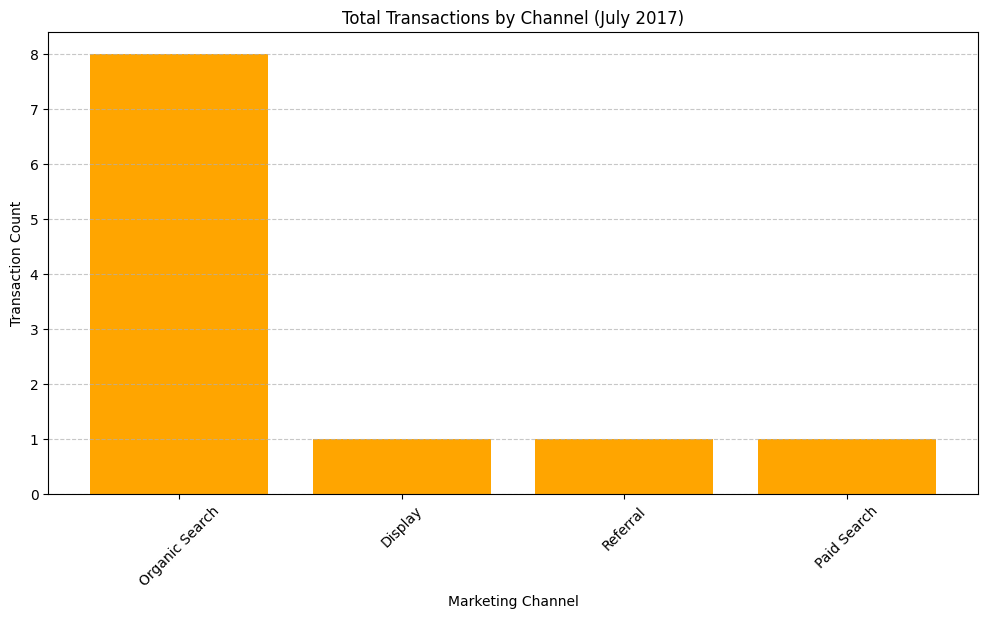

In [21]:
# Part 1: E-commerce Performance Summary (Revenue, Buyers, Patterns)
# Calculate overall performance related to purchase size and revenue per user.
summary_query = """
SELECT
    -- Total unique users who made a purchase
    COUNT(DISTINCT fullVisitorId) AS total_buyers,
    
    -- Total number of successful transactions
    SUM(totals.transactions) AS total_transactions,
    
    -- Total revenue converted to USD (from micro-amounts)
    SUM(totals.totalTransactionRevenue)/1000000 AS total_revenue,
    
    -- Total quantity of individual products sold
    SUM(p.productQuantity) AS total_items_sold,
    
    -- Total pageviews generated by purchasing users
    SUM(IF(totals.transactions >= 1, totals.pageviews, 0)) AS purchaser_pgview

FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits,
    UNNEST(hits.product) AS p

WHERE _TABLE_SUFFIX BETWEEN '20170701' AND '20170702'
  AND hits.eCommerceAction.action_type = '6'       -- Filter for successful 'Purchase' action
"""

# Execute query and convert the first row to a Series for easy access
df_summary = client.query(summary_query).to_dataframe().iloc[0]

# Calculate Secondary Metrics (KPIs) in Python for better readability
avg_purchase_size = df_summary.total_items_sold / df_summary.total_buyers
avg_customer_rev  = df_summary.total_revenue / df_summary.total_buyers
avg_pageviews_pur = df_summary.purchaser_pgview / df_summary.total_buyers

print(f"Average Purchase Size: {avg_purchase_size:.2f} items")
print(f"Average Revenue per Customer: ${avg_customer_rev:.2f}")
print(f"Avg Pageviews per Purchaser: {avg_pageviews_pur:.2f}")


# Part 2: Channel Performance (For Visualization)
# Identify which marketing channels drive the highest number of transactions.
channel_query = """
SELECT 
    channelGrouping AS channel,
    SUM(totals.transactions) AS transactions
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`

WHERE _TABLE_SUFFIX BETWEEN '20170701' AND '20170702'
  AND totals.transactions >= 1      -- Only count sessions that resulted in a transaction

GROUP BY 1
ORDER BY 2 DESC                     -- Sort by transaction volume in descending order
"""

df_channel = client.query(channel_query).to_dataframe()


# --- Part 3: Visualization ---
# Visualize the transaction volume per channel using a bar chart.
plt.figure(figsize=(12, 6))
plt.bar(df_channel['channel'], df_channel['transactions'], color='orange')
plt.title('Total Transactions by Channel (July 2017)')
plt.xlabel('Marketing Channel')
plt.ylabel('Transaction Count')
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add light grid lines for reference
plt.show()